In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss,normalized_mutual_info_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import random
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, fbeta_score

In [28]:
#Load Data
data_jan=pd.read_csv('Jan_data.csv',index_col=0)
data_feb=pd.read_csv('Feb_data.csv',index_col=0)

In [29]:
#Standard Scalar
def scaling(df):
    df = df.reindex(columns=(list([a for a in df.columns if a != 'is_churn']) +['is_churn'] ))
    scaler = preprocessing.StandardScaler()
    scaled_data = scaler.fit_transform(df.iloc[:,:-1])
    scaled_data = pd.DataFrame(scaled_data,columns=df.columns[:-1])
    scaled_data['is_churn']=df.is_churn.values.astype(int)
    scaled_data=scaled_data.set_index([df.index])
    return scaled_data


scaled_data_jan=scaling(data_jan)
scaled_data_feb=scaling(data_feb)

y=scaled_data_jan.is_churn
X=scaled_data_jan.drop(columns=['is_churn'])
y_test=scaled_data_feb.is_churn
X_test=scaled_data_feb.drop(columns='is_churn')

# Remove some 'bad' features and features hvaving high collinearity

In [30]:
bad_features = ['secs_std_14d',
 'percent_whole_song_60d',
 '30d_percent_25',
 'total_secs_7d',
 'percentage_length_30d',
 'unq_mean_14d',
 'percent_whole_song_30d',
 '3060_uniq_diff',
 'secs_std_7d',
 'percent_unique_7d',
 'percentage_length_14d',
 'percent_whole_song_14d',
 'unq_mean_7d',
 'percentage_length_7d',
 '3060_listen_days_diff',
 'percent_whole_song_7d',
 'listening_days_60d',
 'listening_days_30d',
 '1430_listen_diff',
 'listening_days_14d',
 'last_day',
 'listening_days_7d',
 '90_payment_plan_days_sum',
 '90_count_transaction',
 '90_payment_plan_days_mean',
 '30_is_cancel_sum',
 '90_is_cancel_sum',
 'quick_churn',
 'registered_via_13']
X = X.drop(columns= bad_features)
X_test = X_test.drop(columns= bad_features)

In [5]:
#Check correlation
c = X.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort",ascending=False)
so[so!=1].head(46)

percent_whole_song          percentage_length             0.993321
percentage_length           percent_whole_song            0.993321
90_plan_list_price_mean     90_actual_amount_paid_mean    0.984868
90_actual_amount_paid_mean  90_plan_list_price_mean       0.984868
percentage_length           percent_lower25_song          0.982554
percent_lower25_song        percentage_length             0.982554
365_count_transaction       365_payment_plan_days_sum     0.982435
365_payment_plan_days_sum   365_count_transaction         0.982435
180_payment_plan_days_sum   180_count_transaction         0.967153
180_count_transaction       180_payment_plan_days_sum     0.967153
total_secs_30d              total_secs_60d                0.964327
total_secs_60d              total_secs_30d                0.964327
registered_via_7            if_method_id_3                0.964300
if_method_id_3              registered_via_7              0.964300
30_payment_plan_days_sum    30_count_transaction          0.96

In [31]:
#Transpose function
def hlper_fnc(test_list): 
    # declare empty list 
    sub1 = [] 
    sub2 = [] 
  
    res = (sub1, sub2) 
    for sub in test_list: 
        # add element in the last of the list 
        sub1.append(sub[0]) 
        sub2.append(sub[1]) 
  
    return res 

#Drop high colinearity
res = hlper_fnc(so[so!=1].head(46).index.tolist())
drop = res[0][0::2]
X = X.drop(columns= drop)
X_test = X_test.drop(columns= drop)

In [32]:
#Take test and validation set
test_x, X_Validation, test_y, y_Validation = train_test_split(X_test, y_test, test_size=0.3)

# Leaning Curve

In [9]:
#Resample multiple times for learning curve
def logloss_resampling(train,train_y, test, test_y,nruns, sampsize):
    
    loglosses = []
    
    #Logistic regression
    my_model = LogisticRegression(solver='lbfgs',max_iter=1000)
    #fit the models and compute logloss on test data
    for i in range(nruns):
        index_list = np.random.randint(0, len(train), size=sampsize)
        train_samp = train.iloc[index_list]
        y_sample = train_y.iloc[index_list]
        my_model.fit(train_samp,y_sample)
        loglosses.append(log_loss(test_y, my_model.predict_proba(test)[:, 1]))
       
    #Returns the mean(logloss) and SE(logloss)
    return np.mean(loglosses),np.std(loglosses,ddof = 1)/np.sqrt(nruns)

In [25]:
linspace = [2**(i) for i in range(10,19)]
lg_mean = np.zeros(len(linspace))
lg_se = np.zeros(len(linspace))

#Run 20 resampling
for i,size in enumerate(linspace):
    lg_mean[i],lg_se[i]= logloss_resampling(X,y,X_Validation,y_Validation,30, size)
    print('For sample size {}, The mean logloss is {}.'.format(size,lg_mean[i]))

For sample size 1024, The mean logloss is 0.3378351909473393.
For sample size 2048, The mean logloss is 0.32269870079101853.
For sample size 4096, The mean logloss is 0.3169429450366288.
For sample size 8192, The mean logloss is 0.31429886867233436.
For sample size 16384, The mean logloss is 0.31292414353345005.
For sample size 32768, The mean logloss is 0.3118872380207388.
For sample size 65536, The mean logloss is 0.31139998503300215.
For sample size 131072, The mean logloss is 0.31133855846695224.
For sample size 262144, The mean logloss is 0.31095924657547586.


Text(0.5, 1.0, 'Mean Logloss and Confidence Interval For Feature Subset')

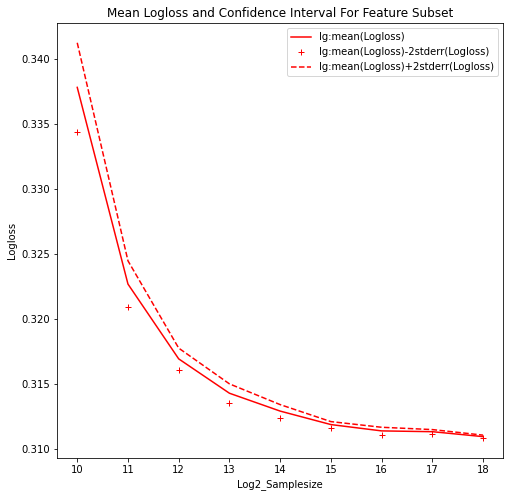

In [26]:
#Make learning curve. plots
plt.figure(figsize = (8,8))
plt.plot(np.log2(linspace),lg_mean,'r',label = 'lg:mean(Logloss)')
plt.plot(np.log2(linspace),lg_mean-2*lg_se,'r+',label = 'lg:mean(Logloss)-2stderr(Logloss)')
plt.plot(np.log2(linspace),lg_mean+2*lg_se,'r--',label = 'lg:mean(Logloss)+2stderr(Logloss)')

plt.legend()
plt.xlabel('Log2_Samplesize')
plt.ylabel('Logloss')
plt.title('Mean Logloss and Confidence Interval For Feature Subset')

In [20]:
#Validation For l2 penalty
train_list = random.sample(X.index.values.tolist(),k=65000)
train = X.loc[train_list]
train_y = y.loc[train_list]

#Use PredefinedSplit
X_con = np.concatenate((train,X_Validation),axis = 0)
y_con = np.concatenate((train_y,y_Validation),axis = 0)
split_index = [-1]*len(train_y)+[0]*len(y_Validation)
pds = PredefinedSplit(test_fold = split_index)


#set up a paramater grid
param_grid_lr = {'C':[10**(i) for i in range(-5,5)], 'penalty':['l2'],
                 'class_weight':[None,{0:0.1,1:0.9},{0:0.2,1:0.8},{0:0.3,1:0.7}],'max_iter':[1000]}

#call the GridSearchCV class, use LogisticRegression and 'F Beta' for scoring
f2_score = make_scorer(fbeta_score, beta=2)

lr_grid_search_2 = GridSearchCV(LogisticRegression(solver='lbfgs'), 
                              param_grid_lr, cv = pds, scoring = f2_score,verbose = 1,n_jobs = -1) 
lr_grid_search_2.fit(X_con, y_con)

Fitting 1 folds for each of 40 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.5s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'class_weight': [None, {0: 0.1, 1: 0.9},
                                          {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}],
                         'max_iter': [1000], 'penalty': ['l2']},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

In [21]:
lr_grid_search_2.cv_results_

{'mean_fit_time': array([0.32002759, 0.34179592, 0.2236445 , 0.31330657, 0.24638867,
        0.35008454, 0.34064436, 0.34062696, 0.45980501, 0.31608009,
        0.47936845, 0.44689727, 0.51682186, 0.71919203, 0.49260759,
        0.81211615, 0.63816166, 1.0101223 , 1.07321525, 0.63260531,
        0.66886091, 1.01893401, 0.60457945, 0.99763584, 0.72359657,
        0.608109  , 0.6084621 , 0.66358781, 0.63636422, 0.70809269,
        0.72590232, 0.74679756, 0.76979756, 0.73648119, 0.61899304,
        0.70192623, 0.77879763, 0.61751223, 0.58157539, 0.60762763]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([0.04878211, 0.05067444, 0.03826404, 0.04193234, 0.03941154,
        0.05065084, 0.04659104, 0.04490948, 0.04465818, 0.04744601,
        0.04393601, 0.04382849, 0.03535891, 0.05145907, 0.04570365,
        0.04

In [15]:
#Validation For l1 penalty
#set up a paramater grid
param_grid_lr = {'C':[10**(i) for i in range(-5,5)], 'penalty':['l1'],
                 'class_weight':[None,{0:0.1,1:0.9},{0:0.2,1:0.8},{0:0.3,1:0.7}]}

#call the GridSearchCV class, use LogisticRegression and 'F beta' for scoring
lr_grid_search_1 = GridSearchCV(LogisticRegression(solver='liblinear'), 
                              param_grid_lr, cv = pds, scoring = f2_score,verbose = 1,n_jobs = -1) 
lr_grid_search_1.fit(X_con, y_con)

Fitting 1 folds for each of 40 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:    5.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.7min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'class_weight': [None, {0: 0.1, 1: 0.9},
                                          {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}],
                         'penalty': ['l1']},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

# Down Sampling

In [33]:
#Drop bad features
scaled_data_jan = scaled_data_jan.drop(columns= bad_features)

#Drop high colinearity
res = hlper_fnc(so[so!=1].head(46).index.tolist())
drop = res[0][0::2]
scaled_data_jan = scaled_data_jan.drop(columns= drop)

#Down Sampling
down_1 = scaled_data_jan[scaled_data_jan.is_churn == 1]
temp = scaled_data_jan[scaled_data_jan.is_churn == 0]
down_0 = scaled_data_jan.sample(n = 27283)
down_train = pd.concat([down_0,down_1])
X = down_train.drop(columns=['is_churn'])
y = down_train.is_churn

In [34]:
#Validation For l2 penalty
train = X
train_y = y

#Use PredefinedSplit
X_con = np.concatenate((train,X_Validation),axis = 0)
y_con = np.concatenate((train_y,y_Validation),axis = 0)
split_index = [-1]*len(train_y)+[0]*len(y_Validation)
pds = PredefinedSplit(test_fold = split_index)


#set up a paramater grid
param_grid_lr = {'C':[10**(i) for i in range(-5,5)], 'penalty':['l2'],
                 'class_weight':[None,{0:0.05,1:0.95},{0:0.1,1:0.9},{0:0.3,1:0.7}],'max_iter':[1000]}

f2_score = make_scorer(fbeta_score, beta=2, pos_label=1)

#call the GridSearchCV class, use LogisticRegression and 'log_loss' for scoring
lr_grid_search_2 = GridSearchCV(LogisticRegression(solver='lbfgs'), 
                              param_grid_lr, cv = pds, scoring = f2_score, verbose = 1,n_jobs = -1) 
lr_grid_search_2.fit(X_con, y_con)

Fitting 1 folds for each of 40 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:    6.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.1s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'class_weight': [None, {0: 0.05, 1: 0.95},
                                          {0: 0.1, 1: 0.9}, {0: 0.3, 1: 0.7}],
                         'max_iter': [1000], 'penalty': ['l2']},
             scoring=make_scorer(fbeta_score, beta=2, pos_label=1), verbose=1)

In [35]:
#Validation For l1 penalty
#set up a paramater grid
param_grid_lr = {'C':[10**(i) for i in range(-5,5)], 'penalty':['l1'],
                 'class_weight':[None,{0:0.1,1:0.9},{0:0.2,1:0.8},{0:0.3,1:0.7}]}

#call the GridSearchCV class, use LogisticRegression and 'F beta' for scoring
lr_grid_search_1 = GridSearchCV(LogisticRegression(solver='liblinear'), 
                              param_grid_lr, cv = pds, scoring = f2_score,verbose = 1,n_jobs = -1) 
lr_grid_search_1.fit(X_con, y_con)

Fitting 1 folds for each of 40 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:    2.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.2s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'class_weight': [None, {0: 0.1, 1: 0.9},
                                          {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}],
                         'penalty': ['l1']},
             scoring=make_scorer(fbeta_score, beta=2, pos_label=1), verbose=1)